# Import Lib

In [71]:
import sys
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

from sklearn.decomposition import PCA

import open3d as o3d
import alphashape
from descartes import PolygonPatch
from shapely.geometry import Polygon
from shapely import affinity



In [72]:
# switch for figure
show_figure = True

# add aixs
aix_points = [[0, 0, 0],
              [0, 0, 100],
              [400, 0, 0],
              [0, 100, 0],
              [-400, 0, 0],]
aix_lines = [[0, 1], # z-aix
             [0, 2], # x-aix
             [0, 3]] # y-aix

colors = [[1,0,1], [0,0,0], [0,0,0]]
aix_line_set = o3d.geometry.LineSet(points=o3d.utility.Vector3dVector(aix_points),
                                    lines=o3d.utility.Vector2iVector(aix_lines))
aix_line_set.colors = o3d.utility.Vector3dVector(colors)

# Read scan model
## import obj file

In [73]:
scan_obj = o3d.io.read_triangle_mesh("./data/femur_half_4.obj")
print(scan_obj)
o3d.visualization.draw_geometries([scan_obj], mesh_show_wireframe=True)

geometry::TriangleMesh with 35027 points and 68786 triangles.


## Scale unit length to 1mm (coordinate 1000x)

In [74]:
points_center = scan_obj.get_center()
print(points_center)
scan_obj.scale(1000.0, points_center)

[ 0.24559977 -0.49631218 -0.23152044]


geometry::TriangleMesh with 35027 points and 68786 triangles.

## change to point cloud

In [75]:
number_of_points = np.asarray(scan_obj.vertices).shape[0]
scan_obj.compute_vertex_normals()
scan_pcd = scan_obj.sample_points_uniformly(number_of_points)

In [76]:
center = scan_pcd.get_center()
center

array([ 0.47389535, -2.06247861, -4.96511104])

# --------------------------------------

## delete plane
### find plane using RANSAC: plane function: ax + by + cz + d = 0

In [77]:
plane_model, inliers = scan_pcd.segment_plane(distance_threshold=2,
                                              ransac_n=3,
                                              num_iterations=1000)
[a, b, c, d] = plane_model
plane = plane_model
print(f"Plane equation: {a:.5f}x + {b:.5f}y + {c:.5f}z + {d:.5f} = 0")

# floor
inlier_cloud = scan_pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])

# bone 
bone_cloud = scan_pcd.select_by_index(inliers, invert=True)

Plane equation: 0.00295x + 0.99997y + -0.00717z + 6.81225 = 0


## Delete outliers

In [78]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [79]:
cl, ind = bone_cloud.remove_statistical_outlier(nb_neighbors=30,
                                                std_ratio=0.5)
# display outliers
display_inlier_outlier(bone_cloud, ind)

Showing outliers (red) and inliers (gray): 


In [80]:
bone_cloud = bone_cloud.select_by_index(ind)

### project point to plane 
link:  \
https://math.stackexchange.com/questions/100761/how-do-i-find-the-projection-of-a-point-onto-a-plane


In [81]:
def point_to_plane(point, plane):
    A = plane[0]
    B = plane[1]
    C = plane[2]
    D = plane[3]

    xi = point[0]
    yi = point[1]
    zi = point[2]

    t = (A*xi + B*yi + C*zi + D) / (A**2 + B**2 + C**2)
    x = xi - A*t
    y = yi - B*t
    z = zi - C*t
    
    res = [x, y, z]
    return res

In [82]:
bone_points = np.array(bone_cloud.points)
bone_points

array([[ 194.0094907 ,   28.51184386,  121.79780193],
       [ 195.08050073,   26.33116242,  122.68432895],
       [ 198.28822254,   27.75667187,  122.02819258],
       ...,
       [-158.61569   ,    1.3542885 ,    7.94577944],
       [-155.46665773,    0.78156257,   10.78326868],
       [-159.58957577,    1.72306585,    7.12946646]])

In [83]:
proj_bone_points = []
for i in range(bone_points.shape[0]):
    point = bone_points[i]
    proj_bone_points.append(point_to_plane(point, plane))

bone_points = np.array(proj_bone_points)
bone_points

array([[ 193.90633776,   -6.50880806,  122.048816  ],
       [ 194.98378   ,   -6.50573957,  122.91969077],
       [ 198.18726156,   -6.51980436,  122.27387269],
       ...,
       [-158.63819982,   -6.28784453,    8.0005552 ],
       [-155.48744811,   -6.27681703,   10.83386033],
       [-159.61318054,   -6.29080464,    7.18690669]])

In [84]:
bone_pcd = o3d.geometry.PointCloud()
bone_pcd.points = o3d.utility.Vector3dVector(bone_points)

o3d.visualization.draw_geometries([bone_pcd, aix_line_set])

### PCA


In [85]:
bone_points = bone_points - bone_points.mean(axis=0, keepdims=True)
print(bone_points)

[[ 1.98778186e+02 -6.37548665e-02  7.27920036e+01]
 [ 1.99855628e+02 -6.06863775e-02  7.36628783e+01]
 [ 2.03059110e+02 -7.47511631e-02  7.30170603e+01]
 ...
 [-1.53766351e+02  1.57208667e-01 -4.12562572e+01]
 [-1.50615600e+02  1.68236164e-01 -3.84229521e+01]
 [-1.54741332e+02  1.54248553e-01 -4.20699057e+01]]


In [86]:
pca = PCA(n_components=3)
pca.fit(bone_points)
pca.components_

array([[ 0.98947788, -0.00187754,  0.14467206],
       [-0.14465426,  0.00751809,  0.9894537 ],
       [ 0.0029454 ,  0.99996998, -0.00716739]])

In [87]:
x_ = pca.components_[0]
y_ =pca.components_[1]
z_ = np.cross(x_, y_)
tran_matrix = np.array([x_, y_, z_])
tran_matrix


array([[ 0.98947788, -0.00187754,  0.14467206],
       [-0.14465426,  0.00751809,  0.9894537 ],
       [-0.0029454 , -0.99996998,  0.00716739]])

In [88]:
bone_after_pca = np.dot(tran_matrix, bone_points.T).T
bone_after_pca

array([[ 2.07217707e+02,  4.32697258e+01, -8.87576676e-15],
       [ 2.08409797e+02,  4.39755826e+01, -1.21196752e-14],
       [ 2.11486166e+02,  4.28730725e+01, -8.17242836e-15],
       ...,
       [-1.58117326e+02, -1.85770161e+01, -2.64890671e-14],
       [-1.54589848e+02, -1.62292787e+01, -2.53237837e-14],
       [-1.59199755e+02, -1.92410708e+01, -2.76632493e-14]])

In [89]:
final_pcd = o3d.geometry.PointCloud()
final_pcd.points = o3d.utility.Vector3dVector(bone_after_pca)
o3d.visualization.draw_geometries([final_pcd, aix_line_set])


## save file

In [90]:
o3d.io.write_point_cloud("./data/2d_bone.ply", final_pcd)


True

In [91]:
type(bone_after_pca)

numpy.ndarray

In [92]:
points = []
text_file = open("./data/2dpoints.txt", "w")
for i in range(bone_after_pca.shape[0]):
    point = bone_after_pca[i]
    x = point[0]
    y = point[1]
    points.append([x, y])
    content = str(x) + ',' + str(y) + '\n'
    text_file.write(content)
text_file.close()


In [93]:
points = np.array(points)



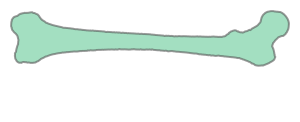

In [94]:
# todo
alpha_shape = alphashape.alphashape(points, 0.4)
# fig, ax = plt.subplots()
# ax.scatter(points[:, 0], points[:,1])
# ax.add_patch(PolygonPatch(alpha_shape, alpha=1))
# plt.show()

alpha_shape

In [95]:
# todo
# same direction with thesis
alpha_shape = affinity.scale(alpha_shape, xfact=1, yfact=-1, origin=(0,0))

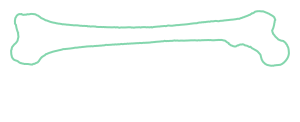

In [96]:
alpha_shape.boundary

In [97]:
type(alpha_shape.boundary)

shapely.geometry.linestring.LineString

In [98]:
alpha_shape.boundary.bounds


(-205.22874531591714,
 -45.895783071577256,
 236.0968016474637,
 40.87753352023898)

In [99]:
line = alpha_shape.exterior
type(line)


shapely.geometry.polygon.LinearRing

## Measurement

### FML

In [100]:
(minx, miny, maxx, maxy) = alpha_shape.exterior.bounds
print(minx, miny, maxx, maxy)
fml = maxx - minx
print('fml: ', fml)

-205.22874531591714 -45.895783071577256 236.0968016474637 40.87753352023898
fml:  441.3255469633808


### FEB


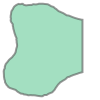

In [101]:
# todo
left_box = Polygon([(minx,miny), (minx, maxy), (minx/1.5,maxy), (minx/1.5, miny)])
left_bone = alpha_shape.intersection(left_box)
left_bone

In [102]:
(left_bone_minx, left_bone_miny, left_bone_maxx, left_bone_maxy) = left_bone.exterior.bounds
print(left_bone_minx, left_bone_miny, left_bone_maxx, left_bone_maxy)
feb = left_bone_maxy - left_bone_miny
print('feb: ', feb)

-205.22874531591714 -44.04417600082388 -136.81916354394477 36.367747586294016
feb:  80.4119235871179


### FBML

In [103]:
left_bone_line = left_bone.exterior

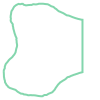

In [104]:
left_bone.boundary

In [105]:
left_bone_points = []
for x,y in left_bone_line.coords:
    left_bone_points.append([x, y])
left_bone_points = left_bone_points[:-1]
len(left_bone_points)

174

In [106]:
left_bone_height = left_bone_maxy - left_bone_miny

In [107]:
max_diff_y = 0
a_idx = 0
for i in range(len(left_bone_points) - 1):
    diff_cur = abs(left_bone_points[i][1] - left_bone_points[i+1][1])
    if  diff_cur > max_diff_y:
        max_diff_y = diff_cur
        a_idx = i
print(a_idx)
print(max_diff_y)
point_a = left_bone_points[a_idx]
point_b = left_bone_points[a_idx + 1]

print(point_a, point_b)

99
45.51290363967978
[-136.81916354394477, 22.41113432082356] [-136.81916354394477, -23.101769318856213]


In [108]:
left_bone_points_ordered = left_bone_points[a_idx+1:] + left_bone_points[:a_idx+1]
len(left_bone_points_ordered)

174

In [109]:
p_left = []
p_left_idx = 0
for i in range(len(left_bone_points_ordered)):
    if left_bone_points_ordered[i][0] == left_bone_minx:
        p_left = left_bone_points_ordered[i]
        p_left_idx = i
        break
print(p_left, 'at: ', p_left_idx)

[-205.22874531591714, -22.327505967737732] at:  74


In [110]:
# in upper part
if left_bone_maxy - p_left[1] < (left_bone_maxy - left_bone_miny) * 0.5:
    left_bone_points_ordered.reverse()
    p_left_idx = len(left_bone_points_ordered) - 1 - p_left_idx

left_bone_points_ordered = left_bone_points_ordered[p_left_idx+1:]
x_min_point_index = 0

# 如果最小的点不是线段头上的前十个点，说明它是P2
while x_min_point_index < 10:
    # 去掉B到current_point， 剩下所有的点里面 最左侧的点找出来
    left_bone_points_ordered = left_bone_points_ordered[x_min_point_index+1:]
    x_min_point = min(left_bone_points_ordered, key = lambda t: t[0])
    x_min_point_index = [i for i, j in enumerate(left_bone_points_ordered) if j == x_min_point][0]

In [111]:
p_left_second = x_min_point
print('p_left_second: ', p_left_second)


p_left_second:  [-199.255312653367, 24.601550314188145]


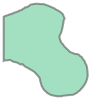

In [112]:
# todo
right_box =  Polygon([(maxx/1.5, miny), (maxx/1.5, maxy), (maxx, maxy), (maxx, miny)])
right_bone = alpha_shape.intersection(right_box)
right_bone

In [113]:
(right_bone_minx, right_bone_miny, right_bone_maxx, right_bone_maxy) = right_bone.exterior.bounds
print(right_bone_minx, right_bone_miny, right_bone_maxx, right_bone_maxy)

157.3978677649758 -45.895783071577256 236.0968016474637 40.87753352023898


In [114]:
right_bone_line = right_bone.exterior

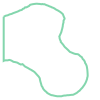

In [115]:
right_bone.boundary

In [116]:
right_bone_points = []
for x,y in right_bone_line.coords:
    right_bone_points.append([x, y])
right_bone_points = right_bone_points[:-1]
len(right_bone_points)

173

In [117]:
max_diff_y = 0
a_idx = 0
for i in range(len(right_bone_points) - 1):
    diff_cur = abs(right_bone_points[i][1] - right_bone_points[i+1][1])
    if  diff_cur > max_diff_y:
        max_diff_y = diff_cur
        a_idx = i
print(a_idx)
print(max_diff_y)
point_a = right_bone_points[a_idx]
point_b = right_bone_points[a_idx + 1]

print(point_a, point_b)

62
3.933638706132596
[211.28563009561114, 14.005907266275205] [209.51273386301654, 10.072268560142609]


In [118]:
right_bone_points_ordered = right_bone_points[a_idx+1:] + right_bone_points[:a_idx+1]
len(right_bone_points_ordered)

173

In [119]:
def distance_point_to_line(p1, p2, p3):
    # point1 and point 2 formed a line, dis is point to that line
    p1 = np.asarray(p1)
    p2 = np.asarray(p2)
    p3 = np.asarray(p3)
    return np.abs(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

fbml = 0
for i in range (len(right_bone_points_ordered)):
    fbml = max(fbml, distance_point_to_line(p_left, p_left_second, right_bone_points_ordered[i]))

print('fbml: ', fbml)


fbml:  438.33896729126093


### FMLD

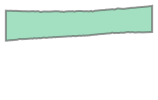

In [120]:
# todo
center_box =  Polygon([(minx/3, miny), (minx/3, maxy), (maxx/3, maxy), (maxx/3, miny)])
center_bone = alpha_shape.intersection(center_box)
center_bone

In [121]:
(center_bone_minx, center_bone_miny, center_bone_maxx, center_bone_maxy) = center_bone.exterior.bounds
print(center_bone_minx, center_bone_miny, center_bone_maxx, center_bone_maxy)

-68.40958177197238 -14.392510134339819 78.6989338824879 20.615247677958873


In [122]:
center_bone_line = center_bone.exterior

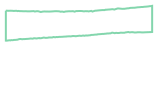

In [123]:
center_bone.boundary

In [124]:
center_bone_points = []
for x,y in center_bone_line.coords:
    center_bone_points.append([x, y])
center_bone_points = center_bone_points[:-1]
len(center_bone_points)

193

In [125]:
center_bone_points = np.asarray(center_bone_points)

In [126]:
import numpy.polynomial.polynomial as poly

center_bone_points_upper = np.asarray([x for x in center_bone_points if x[1] >= 0])
center_bone_points_lower = np.asarray([x for x in center_bone_points if x[1] <= 0])

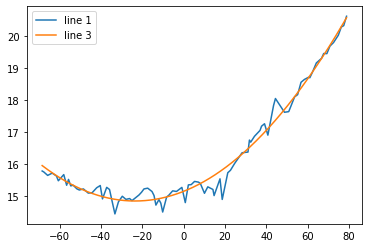

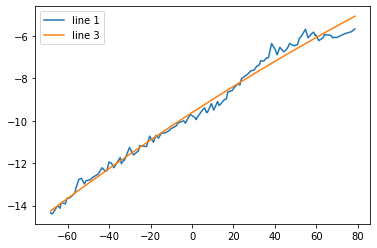

[1.51411611e+01 2.57868864e-02 5.48924619e-04] [-9.60842248e+00  6.31957196e-02 -6.88399831e-05]


In [127]:
def fit_line(points_array):
    x = points_array[:, 0]
    y = points_array[:, 1]
    x_new = np.linspace(x[0], x[-1], num=len(x)*10)

    coefs = poly.polyfit(x, y, 2)
    ffit = poly.polyval(x_new, coefs)

    y_draw = []
    for num in x_new:
        y_draw.append(coefs[2] * num*num + coefs[1] * num + coefs[0])

    if show_figure:
        plt.plot(x, y, label = "line 1")
        #plt.plot(x_new, ffit, label = "line 2")
        plt.plot(x_new, y_draw, label="line 3")

        plt.legend()
        # plt.axes().set_aspect(1)
        plt.show()
    return coefs

# j = coefs_up[3] * (i**3) + coefs_up[2] * (i**2) + coefs_up[1] * i + coefs_up[0]
top_line_p = fit_line(center_bone_points_upper)
bottom_line_p = fit_line(center_bone_points_lower)
print(top_line_p, bottom_line_p)

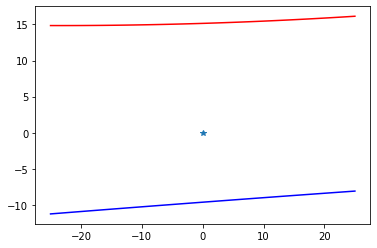

In [128]:
if show_figure:
    x = np.linspace(-25, 25, num=100)
    a = top_line_p[2] * x * x + top_line_p[1] * x + top_line_p[0]
    b = bottom_line_p[2] * x * x + bottom_line_p[1] * x + bottom_line_p[0]
    plt.plot(x, a, 'r') # plotting t, a separately
    plt.plot(x, b, 'b') # plotting t, b separately
    plt.plot([0], [0], '*') # plotting t, c separately
    plt.show()

In [129]:
# vertical line
fmld = poly.polyval(0, top_line_p) - poly.polyval(0, bottom_line_p)
print(fmld)

24.74958353783121


In [130]:
def distance_2_point_to_point(p1, p2):
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

min_line_segment_length = fmld **2
for i in np.arange(-20,20,.01):
    if i == 0:
        continue
    x = i
    y = top_line_p[2] * x * x + top_line_p[1] * x + top_line_p[0]
    k = y/x
    [x_res1, x_res2] = np.roots([bottom_line_p[2], bottom_line_p[1] - k, bottom_line_p[0]])

    y_res1 = k * x_res1
    dis_1 = x_res1 **2 + y_res1**2

    y_res2 = k * x_res2
    dis_2 = x_res2 **2 + y_res2**2

    [x1, y1] = [x_res1, y_res1] if dis_1 < dis_2 else [x_res2, y_res2]

    dis_cur = distance_2_point_to_point([x, y], [x1, y1])
    min_line_segment_length = min(dis_cur, min_line_segment_length)

fmld = math.sqrt(min_line_segment_length)
print('fmld: ', fmld)


fmld:  24.729725784847247


### FHD

In [131]:
#1. 假设骨头的一圈点是个list，这个list是顺时针记录的骨头的点，起点是左上角
# for i in right_bone_points_ordered:
#     print(i)

In [132]:
#2. 找到骨头最右侧的点 max(x)
(right_bone_minx, right_bone_miny, right_bone_maxx, right_bone_maxy) = right_bone.exterior.bounds
print(right_bone_minx, right_bone_miny, right_bone_maxx, right_bone_maxy)

right_most_idx = 0
for i in range(len(right_bone_points_ordered)):
    if right_bone_points_ordered[i][0] == right_bone_maxx:
        right_most_idx = i
        break
right_most_idx

157.3978677649758 -45.895783071577256 236.0968016474637 40.87753352023898


35

In [133]:
#3. 以该点向上五个点开始 找到起点 start_point
start_idx = right_most_idx - 5

In [134]:
#4. 找出start_point代表的斜率为1的曲线tmp_line start_point_y = start_point_x+intercept
start_x = right_bone_points_ordered[start_idx][0]
start_y = right_bone_points_ordered[start_idx][1]
print(start_x, start_y)

# line
intercept = start_y - start_x
intercept

235.595843806959 -19.867123859327872


-255.4629676662869

In [135]:
#5. 从start_point开始 向下遍历点 找y=x+b 和弧线的另一个交点
# line p1: (start_x, start_y), p2:(0, intercept), p3: tmp_point2

p_start = [start_x, start_y]
p_y_inter = [0, intercept]

# right: True; left : False
side = True
end_idx = start_idx + 3
while end_idx < len(right_bone_points_ordered):
    cur_x = right_bone_points_ordered[end_idx][0]
    cur_y = right_bone_points_ordered[end_idx][1]

    if cur_x + intercept > cur_y:
        side = True
    else:
        side = False

    if not side:
        break
    end_idx += 1

line_right_point = [right_bone_points_ordered[end_idx - 1][0], right_bone_points_ordered[end_idx - 1][1]]
line_left_point = [right_bone_points_ordered[end_idx][0], right_bone_points_ordered[end_idx][1]]
print(line_left_point, line_right_point)

dis_right_point = distance_point_to_line(p_start, p_y_inter, line_right_point)
dis_left_point = distance_point_to_line(p_start, p_y_inter, line_left_point)

print(dis_left_point, dis_right_point)

p_start_2 = line_left_point
p_start_2_idx = end_idx
if dis_left_point > dis_right_point:
    p_start_2 = line_right_point
    p_start_2_idx = end_idx - 1

print('start: ', p_start)
print('start2: ', p_start_2)


[208.8717343916289, -45.864546930386474] [209.8966897116685, -45.83365056938188]
0.5138448418300422 0.18906098900284984
start:  [235.595843806959, -19.867123859327872]
start2:  [209.8966897116685, -45.83365056938188]


In [136]:
#6. 计算出点tmp_point2到 tmp_line上的投影点tmp_point3 然后算出来 start_point到tmp_point3的距离dist
# 把dist存入一个list
def distance_point_to_point(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

fhd = distance_point_to_point(p_start, p_start_2)
count_decrease = 0
pre_fhd = fhd
pre_down_left = p_start_2
pre_down_left_idx = p_start_2_idx

In [137]:
#7. start_point开始，向上遍历点 tmp_point1， 更新tmp_line   tmp_point1_y = tmp1_point_x+b
#8. 每次遍历，找到在上次tmp_point2附近的一个新点，使得新点到直线tmp_line距离最短
# tmp_point2更新为新的点，然后计算tmp_point2在直线tmp_line上的投影tmp_point3 到 tmp_point1的距离，存入dist list
# 依次循环,dist应该先增大，后减小，我们要找到的就是增到极大值，开始减小时候的那个极大的距离

def find_down_left(p1, from_idx, right_bone_points_ordered_array):
    cur_intercept = p1[1] - p1[0]
    right_side = True
    while right_side:
        candidate_x = right_bone_points_ordered_array[from_idx][0]
        candidate_y = right_bone_points_ordered_array[from_idx][1]
        if candidate_x + cur_intercept <= candidate_y:
            right_side = False
        from_idx += 1

    left_idx = from_idx - 1
    right_idx = left_idx - 1
    left_dis = distance_point_to_line(p1, [0, cur_intercept], right_bone_points_ordered_array[left_idx])
    right_dis = distance_point_to_line(p1, [0, cur_intercept], right_bone_points_ordered_array[right_idx])

    res_point = right_bone_points_ordered_array[left_idx]
    if left_dis > right_dis:
        res_point = right_bone_points_ordered_array[right_idx]

    return res_point


iterate_idx = start_idx
while iterate_idx > 0:
    p_up_right = right_bone_points_ordered[iterate_idx]

    p_down_left = find_down_left(p_up_right, p_start_2_idx, right_bone_points_ordered)
    cur_fhd = distance_point_to_point(p_up_right, p_down_left)
    fhd = max(fhd, cur_fhd)
    if cur_fhd < fhd:
        count_decrease += 1
        if count_decrease >= 5:
            break
    else:
        count_decrease = 0

    pre_fhd = cur_fhd
    iterate_idx -= 1

print('fhd: ', fhd)


fhd:  46.56326523774694
